In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# エクセル上で前処理を実施
# 実施した前処理
#　　1 車内気温の空欄を対応する車外気温を条件に絞込み車内気温の平均で埋める
#　　2 Specialsからsnowを抽出しダミー変数として追加
#　　3 重量の記録（搭乗者、残油量）が無い為、refill litersを排除、合わせてrefill gasを排除
#　　4 SpecialsからHalfSunHalfRainをrain=0.5,sun=0.5として設定
#　　5 天候に依存してブレーキを踏む回数が増加するとして　rainとsnowの合計をSlipとして追加
#　　6 Specialsは天候とACのダミー変数で賄えるため排除、sunは車外気温に含まれるとして排除
#　　7 gasTypeをダミー変数として分離し、gasTypeごとのデータ、全て含むデータを作成

#走行距離	消費L	走行速度	車内気温	車外気温	エアコン	雨	晴	雪	SP98
df_old = pd.read_csv("measurements6.csv")[['consume','distance','speed','temp_inside','temp_outside','AC','sun','rain','snow','SP98']]


# データの前処理を実施
df_raw = pd.read_csv("measurements.csv")[
    ["distance","consume","speed",
     "temp_inside","temp_outside","specials",
     "gas_type","AC","rain","sun","refill liters",
     "refill gas"]]

# 正規表現による置換
# カンマをピリオドに置換
df_raw = df_raw.replace('(.*),(.*)',r'\1.\2',regex=True)

# 数値項目の型を再設定
for keyName in ["temp_inside","distance","consume"]:
    df_raw[keyName]   = np.array(df_raw[keyName],dtype=float)

# 車内温度の欠損値へ平均を入力
df_raw["temp_inside"] = df_raw["temp_inside"].fillna(df_raw["temp_inside"].mean())

# ガスタイプのダミー変数を追加
df_raw["SP98"]        = np.array(df_raw["gas_type"] == "SP98",dtype=int)

# special中の値を特性名に合わせる
df_raw["snow"] = np.zeros(len(df_raw))
for key,value in [["ac","AC"],["RAIN","rain"],["SUN","sun"],["Sun","sun"],["SNOW","snow"],["half",""]]:
    df_raw["specials"] = df_raw["specials"].replace(key,value,regex=True)
    df_raw["specials"] = df_raw["specials"].replace("(.*)"+key+"(.*)","\1"+value+"\2",regex=True)

# specialをダミー変数として展開
for key in ["AC","rain","sun","snow"]:
    df_raw[key] = np.array( (df_raw[key] + (df_raw["specials"].replace("(.*)"+key+"(.*)","1",regex=True) == "1")) > 0,dtype=int)

# 給油の有無をダミー変数として追加
df_raw["refill"] = np.array(df_raw["refill liters"] > "1",dtype=int)

# 平均時速と移動距離から時間を追加
df_raw["time"]   = df_raw["distance"]/df_raw["speed"]

# 処理用のデータとして整形
df = df_raw[["distance","consume","speed","time","temp_inside","temp_outside","AC","rain","sun","snow","SP98","refill"]]

display(df.info())
display(df.head())
display(df.describe())

randomValue = 200
splitSize    = 5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
time            388 non-null float64
temp_inside     388 non-null float64
temp_outside    388 non-null int64
AC              388 non-null int32
rain            388 non-null int32
sun             388 non-null int32
snow            388 non-null int32
SP98            388 non-null int32
refill          388 non-null int32
dtypes: float64(4), int32(6), int64(2)
memory usage: 27.4 KB


None

,distance,consume,speed,time,temp_inside,temp_outside,AC,rain,sun,snow,SP98,refill
0,28.0,5.0,26,1.076923,21.5,12,0,0,0,0,0,1
1,12.0,4.2,30,0.400000,21.5,13,0,0,0,0,0,0
2,11.2,5.5,38,0.294737,21.5,15,0,0,0,0,0,0
3,12.9,3.9,36,0.358333,21.5,14,0,0,0,0,0,0
4,18.5,4.5,46,0.402174,21.5,15,0,0,0,0,0,0


,distance,consume,speed,time,temp_inside,temp_outside,AC,rain,sun,snow,SP98,refill
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,0.444047,21.929521,11.358247,0.079897,0.123711,0.085052,0.010309,0.587629,0.033505
std,22.667837,1.033172,13.598524,0.311357,0.994666,6.991542,0.271484,0.329677,0.279319,0.101140,0.492897,0.180184
min,1.300000,3.300000,14.000000,0.061905,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,0.274419,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,0.366667,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,19.000000,5.300000,50.000000,0.518056,22.500000,16.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,216.100000,12.200000,90.000000,2.637500,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
y_ALL      = df['consume']
# 線形回帰用　車内温度は不要
X_ALL      = df[['distance','speed','time','temp_outside','AC','sun','rain','snow','SP98','refill']]
# 決定木用
X_ALL_CORR = df[['distance','speed','time','temp_inside','temp_outside','AC','sun','rain','snow','SP98','refill']]
X_ALL_old2 = df_old[['distance','speed','temp_inside','temp_outside','AC','sun','rain','snow','SP98']]


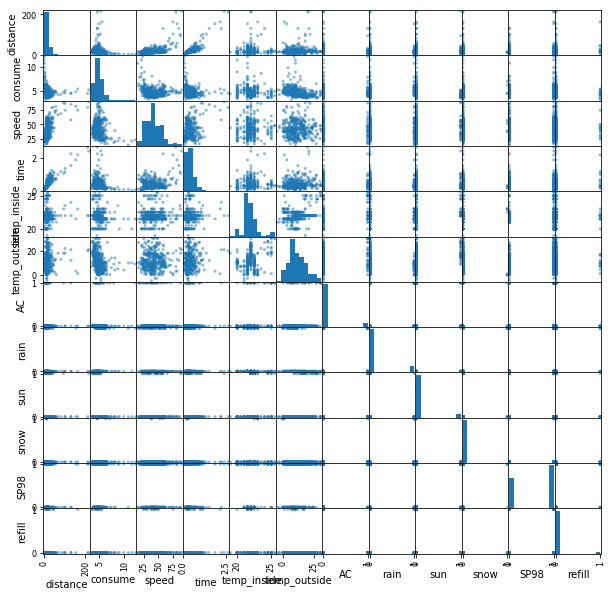

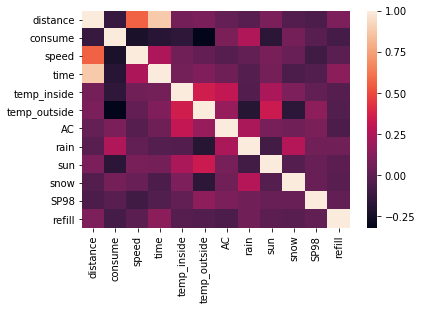

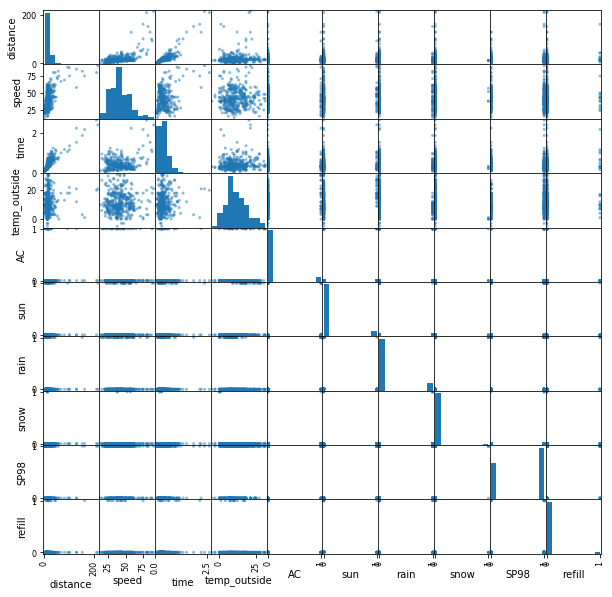

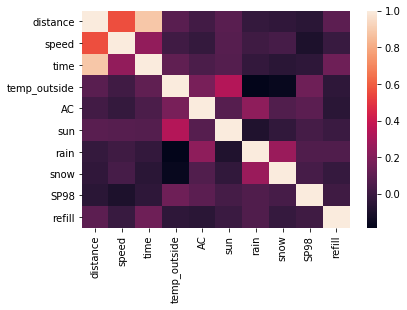

In [14]:
pd.plotting.scatter_matrix(df,figsize=(10,10))
plt.show()
sns.heatmap(df.corr())
plt.show()

pd.plotting.scatter_matrix(X_ALL,figsize=(10,10))
plt.show()
sns.heatmap(X_ALL.corr())
plt.show()

In [15]:
##  無相関化を行うための一連の処理
X_ALL_C2  = np.array(X_ALL[['speed','distance','time']])

convertSet = [X_ALL_C2]
convertedSet = []
for data1 in convertSet:
    cov = np.cov(data1, rowvar=0)         # 分散・共分散を求める
    _, S = np.linalg.eig(cov)             # 分散共分散行列の固有ベクトルを用いて
    data1_decorr = np.dot(S.T, data1.T).T #データを無相関化
    convertedSet.append(data1_decorr)

X_ALL_C2_CONVERTED  = convertedSet[0]

X_ALL.loc[:,'speed']     = X_ALL_C2_CONVERTED[ :,0]
X_ALL.loc[:,'distance']  = X_ALL_C2_CONVERTED[ :,1]
X_ALL.loc[:,'time']  = X_ALL_C2_CONVERTED[ :,2]



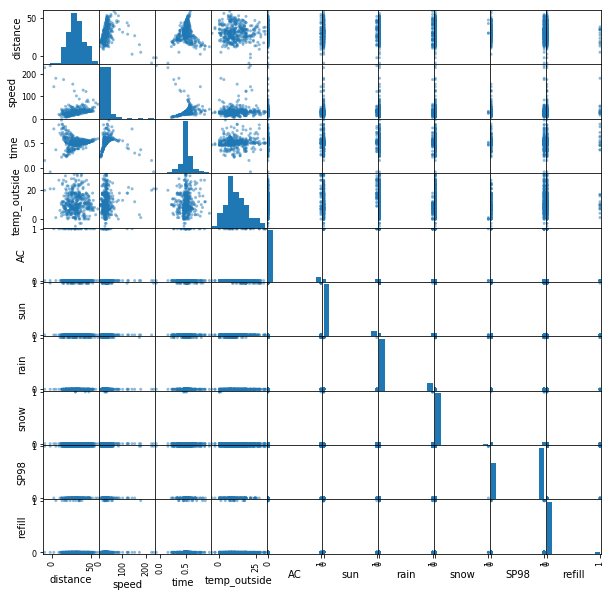

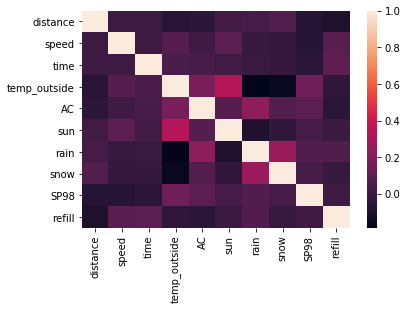

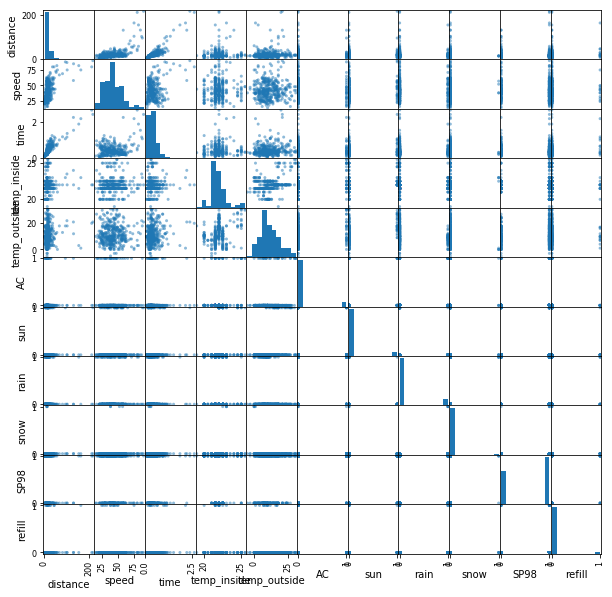

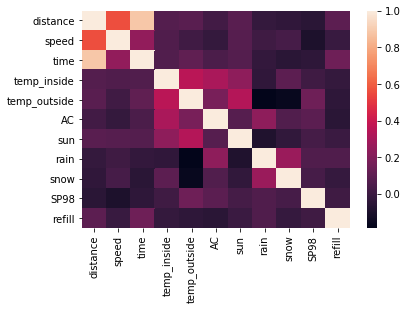

In [16]:
pd.plotting.scatter_matrix(X_ALL,figsize=(10,10))
plt.show()
sns.heatmap(X_ALL.corr())      # 決定木用
plt.show()
pd.plotting.scatter_matrix(X_ALL_CORR,figsize=(10,10))
plt.show()
sns.heatmap(X_ALL_CORR.corr()) # 線形回帰用
plt.show()

In [17]:
print(X_ALL.info())
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 10 columns):
distance        388 non-null float64
speed           388 non-null float64
time            388 non-null float64
temp_outside    388 non-null int64
AC              388 non-null int32
sun             388 non-null int32
rain            388 non-null int32
snow            388 non-null int32
SP98            388 non-null int32
refill          388 non-null int32
dtypes: float64(3), int32(6), int64(1)
memory usage: 21.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 16 columns):
distance         388 non-null float64
consume          388 non-null float64
speed            388 non-null int64
temp_inside      388 non-null float64
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int32
rain             388 non-null int32
sun              388 non-null int32
r

# 説明変数のスケーリングを個別に行う

In [18]:
from sklearn.preprocessing import StandardScaler
# ダミー変数を処理する事を回避するため平均と標準偏差の合計が指定値を下回る変数は処理しない
def scaleOnlyLarge(_X_train,_X_test,Large = 1):
    for i in range(_X_train.shape[1]):
        if abs(_X_train[:,i].mean()) + _X_train[:,i].std()  > Large:
            mean = _X_train[:,i].mean()
            std  = _X_train[:,i].std()
            _X_train[:,i] = ( _X_train[:,i] - mean ) / std
            _X_test[:,i]  = ( _X_test[:,i]  - mean ) / std
            
    ret = []
    ret.append(_X_train)
    ret.append(_X_test)
    return ret

# ダミー変数を処理する事を回避するため、0か1のデータを避けてスケーリング
def scaleOtherThanDummy(_X_train,_X_test):
    for i in range(_X_train.shape[1]):
        uniqueKey = np.unique(_X_train[:,i])
        if ((uniqueKey == 0) + (uniqueKey == 1)).min() == False:
            mean = _X_train[:,i].mean()
            std  = _X_train[:,i].std()
            _X_train[:,i] = ( _X_train[:,i] - mean ) / std
            _X_test[:,i]  = ( _X_test[:,i]  - mean ) / std
            
    ret = []
    ret.append(_X_train)
    ret.append(_X_test)
    return ret
    


# データに合わせたテスト実行クラスの実装

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

class test:
    def __init__(self):
        self.Random = -1
        self.Split  = -1
        
    def setRandom(self,_random):
        self.Random = _random

    def setSplit(self,_split):
        self.Split = _split
    
    def getRandom(self):
        return self.Random
    def getSplit(self):
        return self.Split
    
    def do(self,_model):
        return {"mse_train":0,"mse_test":0}

    def modelKick(self,_model,_X_train,_y_train,_X_test,_y_test):
        _model.fit(_X_train, _y_train)
        y_pred_train = _model.predict(_X_train)
        y_pred_test  = _model.predict(_X_test)
        mse_train = mean_squared_error(_y_train, y_pred_train)
        mse_test  = mean_squared_error(_y_test,  y_pred_test)
        return {"mse_train":mse_train,"mse_test":mse_test}
    
    def scaling(self,_X_train,_X_test):
        ret = []
        scaler = StandardScaler()
        scaler.fit(_X_train)
        ret.append(scaler.transform(_X_train))
        ret.append(scaler.transform(_X_test))
        return ret
    
class foldOutTest(test):
    def __init__(self,_X,_y,_random,scaleFunc=None,_isSuffle=True):
        
        self.setRandom(_random)
        datas = train_test_split(np.array(_X), np.array(_y), test_size=0.2,shuffle=_isSuffle,random_state = _random)
        self.X_train = datas[0]
        self.X_test  = datas[1]
        self.y_train = datas[2]
        self.y_test  = datas[3]

        if scaleFunc == None:
            self.X_train,self.X_test = self.scaling(self.X_train,self.X_test)
        else:
            self.X_train,self.X_test = scaleFunc(self.X_train,self.X_test)
        
    def do(self,_model):
        return self.modelKick(_model,self.X_train,self.y_train,self.X_test,self.y_test)

class kFoldTest(test):
    def __init__(self,_X,_y,_split,_random,scaleFunc=None,_isSuffle=True):

        self.setSplit(_split)
        self.setRandom(_random)

        self.split = _split
        splitter = KFold(n_splits=_split, shuffle=_isSuffle, random_state=_random)

        self.X_train = []
        self.y_train = []
        self.X_test  = []
        self.y_test  = []

        
        X = np.array(_X)
        y = np.array(_y)
        
        for train_idx, test_idx in splitter.split(X,y):

            X_train_k, y_train_k = X[train_idx], y[train_idx] #学習用データ
            X_test_k, y_test_k   = X[test_idx] , y[test_idx]  #テスト用データ

            if scaleFunc == None:
                X_train_k,X_test_k = self.scaling(X_train_k,X_test_k)
            else:
                X_train_k,X_test_k = scaleFunc(X_train_k,X_test_k)

            self.X_train.append(X_train_k)
            self.y_train.append(y_train_k)
            self.X_test.append(X_test_k)
            self.y_test.append(y_test_k)

    def do(self,_model):
        mse_test_sum  = 0
        mse_train_sum = 0
        for i in range(self.split):
            mse_pair = self.modelKick(_model,self.X_train[i],self.y_train[i],self.X_test[i],self.y_test[i])
            mse_test_sum  += mse_pair["mse_test"]
            mse_train_sum += mse_pair["mse_train"]
        
        mse_test  = mse_test_sum / self.split
        mse_train = mse_train_sum / self.split

        return {"mse_train":mse_train,"mse_test":mse_test}


# テストデータを取り込んでパラメーターに合わせたテスト実行クラスの実装

In [20]:
# これは他所でも使う関数なので外に置く
def checkTypeNone(_value):
    return type(_value) != type(None)

# 簡易版のモノステートパターンで実装
class modelTest:
    def __init__(self,_test,_model):
        self.test   = _test
        self.isList = False
        self.isDict = False
        self.model  = None
        self.setModels(_model)
    
    # パイプを考慮したモデルの設定
    def setModels(self,_model):
        if type(_model) == type([]):
            self.isList = True
            self.isDict = False
            # リスト型で渡された場合はPipeを作成する
            self.model  = Pipeline(steps=[("Step0",_model[0])])
            for i in range(1,len(_model)):
                self.model.steps.append(("Step"+str(i),_model[i]))
        elif type(_model) == type({}):
            self.isList = True
            self.isDict = True
            # リスト型で渡された場合はPipeを作成する
            first = True
            for item in _model.items():
                if first:
                    self.model = Pipeline(steps=[item])
                    first      = False
                else:
                    self.model.steps.append(item)
        else:
            self.isList = False
            self.model  = _model
    
    # 乱数の固定
    def setRandomState(self,_random):
        prefix      = ""
        randomParam = {"random_state":_random}
        if type(self.model) == Pipeline:
            self.setParams2Model(self.model,randomParam,prefix)
            for stepName,model in self.model.steps:
                self.setParams2Model(model,randomParam,prefix)
        else:
            self.setParams2Model(self.model,randomParam,prefix)

    # モデルのパラメーター制御、指定された型毎に制御
    # Pipeが指定されている場合はその中までパラメーターを設定する
    def setParams(self,_model,_hyperParam,_prefix = ""):
        if type(_model) == Pipeline:
            self.setParams2ModelList(_model,_hyperParam,_prefix)
        else:
            self.setParams2Model(_model,_hyperParam,_prefix)
            
    def getParams(self,_model,_hyperParam,_prefix = ""):
        if type(_model) == Pipeline:
            return self.getParams2ModelList(_model,_hyperParam,_prefix)
        else:
            return self.getParams2Model(_model,_hyperParam,_prefix)

    # pipeとして設定されているモデルのパラメーター制御
    def setParams2ModelList(self,_model,_hyperParam,_prefix = ""):
        self.setParams2Model(_model,_hyperParam,_prefix)
        for stepName,model in _model.steps:
            if self.isDict:
                self.setParams2Model(model,_hyperParam,stepName)
            else:
                self.setParams2Model(model,_hyperParam,_prefix)
                
    def getParams2ModelList(self,_model,_hyperParam,_prefix = ""):
        ret = {}
        ret.update(self.getParams2Model(_model,_hyperParam,_prefix))
        for stepName,model in _model.steps:
            if self.isDict:
                ret.update(self.getParams2Model(model,_hyperParam,stepName))
            else:
                ret.update(self.getParams2Model(model,_hyperParam,_prefix))
        return ret

    # モデルのパラメーター制御
    def setParams2Model(self,_model,_hyperParam,_prefix = ""):
        for key in _hyperParam.keys():
            keyModel = key
            if key.find(_prefix) == 0:
                keyModel = key.replace(_prefix,"",1)
            if checkTypeNone(_hyperParam.get(key)) & ( keyModel in _model.__dict__ ):
                _model.__dict__[keyModel] = _hyperParam[key]
                
    def getParams2Model(self,_model,_hyperParam,_prefix = ""):
        ret = {}
        for key in ["alpha","cv","l1_ratio","degree","max_depth",
                      "min_impurity_decrease","min_impurity_split",
                      "min_samples_leaf","min_samples_split","n_estimators"]:
            if ( key in _model.__dict__ ):
                keyParam = _prefix + key
                ret[keyParam] = _model.__dict__[key]
        for key in _hyperParam.keys():
            keyModel = key
            if key.find(_prefix) == 0:
                keyModel = key.replace(_prefix,"",1)
            if ( keyModel in _model.__dict__ ):
                ret[key] = _model.__dict__[keyModel]

        for valueKey,key in [["coef_","wait"],["intercept_","bias"],["feature_importances_","impotances"]]:
            if ( valueKey in _model.__dict__ ):
                ret[key] = _model.__dict__[valueKey]
            
        return ret
    
    # モデルの実行
    def do(self,_hyperParam):
        self.setParams(self.model,_hyperParam)
        self.setRandomState(self.test.getRandom())
        mse_ret = self.test.do(self.model)
        ret = {"random":self.test.getRandom()}
        ret.update(self.getParams(self.model,_hyperParam))
        ret.update(mse_ret)
        return ret

    # アダブースト回帰モデルの実行
    # アダブースト用のパラメーターには任意の接頭辞を設定
    def doAdaBoostReg(self,_hyperParam,_prefix = "ada_"):
        self.setParams(self.model,_hyperParam,"")
        self.setRandomState(self.test.getRandom())
        adbClf = AdaBoostRegressor(self.model,random_state=self.test.getRandom())
        self.setParams(adbClf,_hyperParam,_prefix)
        mse_ret = self.test.do(adbClf)
        ret = {"random":self.test.getRandom()}
        ret.update(self.getParams(adbClf,_hyperParam,_prefix))
        ret.update(self.getParams(self.model,_hyperParam))
        ret.update(mse_ret)
        return ret

class modelTestNorand(modelTest):
    # 乱数不定版
    def setRandomState(self,_random):
        return ""


# 各モデルの実装

In [21]:
# 各モデルの実装
from sklearn.linear_model  import Lasso   as L1,  Ridge   as L2,  ElasticNet   as EN,  LinearRegression   as Line
from sklearn.linear_model  import LassoCV as L1CV,RidgeCV as L2CV,ElasticNetCV as ENCV
from sklearn.metrics       import mean_squared_error
from sklearn.ensemble      import AdaBoostRegressor,RandomForestRegressor
from sklearn.tree          import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline      import Pipeline

import warnings
warnings.filterwarnings('ignore')


def linearTest(_test,_hyperParam = {"alpha":-1}):
    return modelTest(_test,Line()).do(_hyperParam)

def lassoTest(_test,_hyperParam):
    return modelTest(_test,L1()).do(_hyperParam)

def ridgeTest(_test,_hyperParam):
    return modelTest(_test,L2()).do(_hyperParam)

def elasticNetTest(_test,_hyperParam):
    return modelTest(_test,EN()).do(_hyperParam)

def DTregTest(_test,_hyperParam):
    return modelTest(_test,DecisionTreeRegressor()).do(_hyperParam)

def RFregTest(_test,_hyperParam):
    return modelTest(_test,RandomForestRegressor()).do(_hyperParam)

def RFregTestNorand(_test,_hyperParam):
    return modelTestNorand(_test,RandomForestRegressor()).do(_hyperParam)

# Alphasを使用しないため、CrossValidationは使わない、書くだけ
def CVTest(_test,_model,_hyperParam):
    cv    = 5
    if checkTypeNone(_hyperParam.get("cv")):
        cv = _hyperParam["cv"]
    alpha = 1
    if checkTypeNone(_hyperParam.get("alpha")):
        alpha = _hyperParam["alpha"]
    hyperParam = dict(_hyperParam)
    hyperParam["alphas"] = np.ones(cv) * alpha
    test = modelTest(_test,_model())
    ret = test.do(hyperParam)
    ret["alpha"] = alpha
    return ret

def lassoCVTest(_test,_hyperParam):
    return CVTest(_test,L1CV,_hyperParam)

def ridgeCVTest(_test,_hyperParam):
    return CVTest(_test,L2CV,_hyperParam)

def elasticNetCVTest(_test,_hyperParam):
    return CVTest(_test,ENCV,_hyperParam)

# 多項式による回帰のテスト
def PolynominalLineTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),Line()]).do(_hyperParam)

def PolynominalL1Test(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),L1()]).do(_hyperParam)

def PolynominalL2Test(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),L2()]).do(_hyperParam)

def PolynominalENTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),EN()]).do(_hyperParam)

def PolynominalDTTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),DecisionTreeRegressor()]).do(_hyperParam)

def PolynominalRFTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),RandomForestRegressor()]).do(_hyperParam)

def adaBoostTest(_test,_model,_hyperParam):
    return modelTest(_test,_model(),_hyperParam)

def AdaPolynominalLineTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),Line()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalL1Test(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),L1()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalL2Test(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),L2()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalENTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),EN()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalDTTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),DecisionTreeRegressor()]).doAdaBoostReg(_hyperParam)

def AdaPolynominalRFTest(_test,_hyperParam):
    return modelTest(_test,[PolynomialFeatures(),RandomForestRegressor()]).doAdaBoostReg(_hyperParam)

def adbL1Test(_test,_hyperParam):
    return modelTest(_test,L1()).doAdaBoostReg(_hyperParam)

def adbL2Test(_test,_hyperParam):
    return modelTest(_test,L2()).doAdaBoostReg(_hyperParam)

def adbENTest(_test,_hyperParam):
    return modelTest(_test,EN()).doAdaBoostReg(_hyperParam)

def adbDTTest(_test,_hyperParam):
    return modelTest(_test,DecisionTreeRegressor()).doAdaBoostReg(_hyperParam)

def adbRFTest(_test,_hyperParam):
    return modelTest(_test,RandomForestRegressor()).doAdaBoostReg(_hyperParam)




## 最適パラメーターのチェック

In [22]:
def checkAHyperParam(_alpha,_MSE):
    bestAlpha  = -1
    minMse    = 100000000000
    
    ret = {"bestAlpha":-1,"minMse":100000000000}

    for i in range(_alpha.size):
        if _MSE[i] < minMse:
            minMse = _MSE[i]
            bestAlpha = _alpha[i]

    ret["bestAlpha"] = bestAlpha
    ret["minMse"]   = minMse
    return ret

def check2HyperParam(_alphas,_MSEs,_Ratios):
    bestAlpha  = -1
    bestRatio = -1
    minMse    = 100000000000

    ret = {"bestAlpha":-1,"bestRatio":-1,"minMse":100000000000}

    for i in range(_Ratios[:,0].size):
        for j in range(_alphas[i,:].size):
            if _MSEs[i,j] < minMse:
                minMse = _MSEs[i,j]
                bestAlpha = _alphas[i,j]
                bestRatio = _Ratios[i,j]
    
    ret["bestAlpha"]  = bestAlpha
    ret["bestRatio"] = bestRatio
    ret["minMse"]    = minMse
    return ret


## WaitとMSEの表示

In [23]:
def showOneGraph(_label,_alpha,_MSE):
    plt.figure(figsize=(16,4))
    plt.plot(_alpha,_MSE,label=_label,color='C1')
    plt.grid(which='major',color='black',linestyle=':')
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    plt.legend()
    plt.show()
    
    hyperParam = checkAHyperParam(_alpha,_MSE)
    print("{} 二乗誤差、最小：{:.3f} 最適な係数：{:.3f}".format(_label,hyperParam["minMse"],hyperParam["bestAlpha"]))
    print("")

def showTwoGraph(_label,_alpha,_MSE_train,_MSE_test):
    plt.figure(figsize=(16,4))
    plt.plot(_alpha,_MSE_train,label="{} Train".format(_label),color='C1')
    plt.plot(_alpha,_MSE_test,label="{} Test".format(_label),color='C2')
    plt.grid(which='major',color='black',linestyle=':')
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    plt.legend()
    plt.show()
    
    hyperParam = checkAHyperParam(_alpha,_MSE_train)
    print("{} 訓練 二乗誤差、最小：{:.3f} 最適な係数：{:.3f}".format(_label,hyperParam["minMse"],hyperParam["bestAlpha"]))
    hyperParam = checkAHyperParam(_alpha,_MSE_test)
    print("{} 汎化 二乗誤差、最小：{:.3f} 最適な係数：{:.3f}".format(_label,hyperParam["minMse"],hyperParam["bestAlpha"]))
    print("")

def showMultiGraph(_label,_alphas,_MSEs,_Ratios):
    plt.figure(figsize=(16,4))
    plt.grid(which='major',color='black',linestyle=':')
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    for i in range(_Ratios[:,0].size):
        plt.plot(_alphas[i,:],_MSEs[i,:],label="{} {:.3f}".format(_label,_Ratios[i,0]))
        
    plt.legend()
    plt.show()

    hyperParam = check2HyperParam(_alphas,_MSEs,_Ratios)
    print("{}  二乗誤差、最小：{:.3f} 最適な係数：{:.3f} L1の寄与率：{:.6f}".format(
        _label,
        hyperParam["minMse"],
        hyperParam["bestAlpha"],
        hyperParam["bestRatio"]))
    print("")

def showMultiGraph2(_label,_alphas,_MSEs,_Ratios):
    plt.figure(figsize=(16,4))
    plt.grid(which='major',color='black',linestyle=':')
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    for i in range(_Ratios[:,0].size):
        plt.plot(_alphas[i,:],_MSEs[i,:],label="{} {:.3f}".format(_label,_Ratios[i,0]))
        
    plt.legend()
    plt.show()

    hyperParam = check2HyperParam(_alphas,_MSEs,_Ratios)
    print("{}  二乗誤差、最小：{:.3f} 最適な分割数：{:.3f} 最適な不純度の許容値：{:.6f}".format(
        _label,
        hyperParam["minMse"],
        hyperParam["bestAlpha"],
        hyperParam["bestRatio"]))
    print("")


# グリッドサーチの実装

In [24]:
class Tuning:
    def __init__(self):
        self.result = pd.DataFrame()
    # 複数の係数をグリッドサーチで検索する場合
    # 最適なパラメーターを計算した後にグラフ化して遷移を見たい
    # 最適なパラメーターにおける横の変化率だけ確認する？
    # また末端の変化率が下降傾向で止まっているデータについて探索が完了していないことを警告する？
    def gridSearch(self,_testData,_testFunc,_hyperParamDict):

        #パラメーターのデータセットは辞書型で渡る想定
        # {"パラメーター名":係数リスト,"パラメーター名":係数リスト}
        # 汎化誤差、訓練誤差、各実行パラメーターを持つリストを生成する
        # 0＝汎化誤差、1＝訓練誤差、2～＝パラメーター
        rowSize   = len(_hyperParamDict.keys()) + 2
        totalSize = 1
        counter   = {"keys"          :[],
                     "useCount"      :[],
                     "replaceOffset" :[],
                     "replacingCount":[]}

        for key in _hyperParamDict.keys():
            counter["keys"].append(key)
            counter["replaceOffset"].append(totalSize)
            counter["replacingCount"].append(1)
            counter["useCount"].append(0)
            totalSize = totalSize * len(_hyperParamDict[key])

        counter["replaceOffset"]  = np.array(counter["replaceOffset"]) 
        counter["replacingCount"] = np.array(counter["replacingCount"])
        counter["useCount"]       = np.array(counter["useCount"])

        hyperParam = {}
        hyperParamList = np.ones(totalSize * rowSize).reshape(totalSize,rowSize)
        min_mse    = 100000000000
        min_result = {}
        bestIndex  = -1
        for index in range(totalSize):

            counter["replacingCount"] -= 1
            for hyperParamIndex,isReplace in zip(range(rowSize-2),counter["replacingCount"] == 0):
                if isReplace:
                    keyName    = counter["keys"][hyperParamIndex]
                    useCount   = counter["useCount"][hyperParamIndex]
                    resetCount = counter["replaceOffset"][hyperParamIndex]

                    hyperParam[keyName]                        = _hyperParamDict[keyName][useCount]
                    counter["useCount"][hyperParamIndex]       = ( useCount + 1 ) % len(_hyperParamDict[keyName])
                    counter["replacingCount"][hyperParamIndex] = resetCount

            result = _testFunc(_testData,hyperParam)
            hyperParamList[index,0]  = result["mse_test"]
            hyperParamList[index,1]  = result["mse_train"]
            hyperParamList[index,2:] = list(hyperParam.values())

            if min_mse > hyperParamList[index,0]:
                min_result = result
                min_mse    = hyperParamList[index,0]
                bestIndex  = index

        col  = ["mse_test","mse_train"]
        keys = list(_hyperParamDict.keys())
        col  = col + keys
        df   = pd.DataFrame(list(hyperParamList[:,:]))
        df.columns = col
        self.result = min_result
        self.result.update({"min_mse":min_mse,"bestIndex":bestIndex,"testResult":df})
        return self.result
    
    def displayBest(self,_label=""):
        bestIndex = self.result["bestIndex"]
        df  = self.result["testResult"]
        if _label != "":
            print(_label)
        display(df.loc[bestIndex:bestIndex])
        print("{}訓練誤差：{:.3f}".format(_label,df.loc[bestIndex]["mse_train"]))
        print("{}汎化誤差：{:.3f}".format(_label,df.loc[bestIndex]["mse_test"]))        

    def showGraph(self,_Train=True,_label=""):
        bestIndex = self.result["bestIndex"]
        df        = self.result["testResult"]

        values    = df.loc[bestIndex]
        keys      = list(df.loc[bestIndex:bestIndex])[2:]
        entrys    = zip(keys,list(values)[2:])
        wheres    = []
        getGraphs = {}

        for key,value in entrys:
            where  = " " + key + " == " + str(value) + " "
            wheres.append(str(where))

        keyIndexs  = zip(keys,range(len(wheres)))

        for key,index in keyIndexs:
            cnt = -1
            whereKey = ""
            prefix   = ""
            for where in wheres:
                cnt += 1
                if cnt == index:
                    continue
                    
                whereKey = whereKey + prefix + where
                prefix   = "&"

            if whereKey != "":
                getGraphs[key] = df.query(whereKey)
            else:
                getGraphs[key] = df

        self.displayBest(_label)
        for hyperParamName,graphValue in getGraphs.items():
            
            print("Optimized {}：{}".format(hyperParamName,values[hyperParamName]))

            xHyperParam = graphValue[[hyperParamName]]
            yTrain      = graphValue[["mse_train"]]
            yTest       = graphValue[["mse_test"]]

            plt.figure(figsize=(16,4))
            plt.grid(which='major',color='black',linestyle=':')
            plt.xlabel(hyperParamName)
            plt.ylabel("mse")
            
            plt.plot(xHyperParam,yTest, label="Test")
            if _Train:
                plt.plot(xHyperParam,yTrain,label="Train")

            plt.legend()
            plt.show()

            print("")        

    def printParam(self,_label=""):
        waitOut = "{} ".format(_label)
        if checkTypeNone(self.result.get("wait")):
            for i in range(len(self.result["wait"])):
                waitOut += " 重み{:d}：{:.3f}".format(i+1,self.result["wait"][i])
            print(waitOut)
        importancesOut = "{} ".format(_label)
        if checkTypeNone(self.result.get("importances")):
            for i in range(len(self.result["importances"])):
                importancesOut += " 重要度{:d}：{:.3f}".format(i+1,self.result["importances"][i])
            print(importancesOut)
        if checkTypeNone(self.result.get("bias")):
            print("{} バイアス：{:.3f}".format(_label,self.result["bias"]))
        if checkTypeNone(self.result.get("mse_train")):
            print("{} 訓練 二乗誤差：{:.3f}".format(_label,self.result["mse_train"]))
        if checkTypeNone(self.result.get("mse_test")):
            print("{} 汎化 二乗誤差：{:.3f}".format(_label,self.result["mse_test"]))
        if checkTypeNone(self.result.get("l1_ratio")):
            print("{} L1正則化比重：{:.3f}".format(_label,self.result["l1_ratio"]))
        print("")

# Day1、２の処理結果
### 訓練誤差を確認した所、結果の逆転するテストデータパラメーターであった
### テストデータ生成方法は変更する

In [25]:
# Lasso、Ridge、ElasticNetのどれを使ってもどんぐりの背比べの状態
# Ridge向き？

# speed：-0.120756
# temp_inside：-0.054757
# temp_outside：-0.169525
# AC：0.048508
# sun：-0.031087
# rain：0.137269
testALLFoldOut  = foldOutTest(X_ALL_old2,y_ALL,100,None,True)
tuningObject = Tuning()
result = tuningObject.gridSearch(testALLFoldOut,elasticNetCVTest,
          {"alpha":   np.array([0.571]),
           "l1_ratio":np.array([0.081]),
           "cv":      np.array([5]),
          })
tuningObject.displayBest()

,mse_test,mse_train,alpha,l1_ratio,cv
0,0.661907,0.932436,0.571,0.081,5.0


訓練誤差：0.932
汎化誤差：0.662


# 簡易モデルの作成（説明変数は前処理済み）
## Day2テストデータでの各モデルの誤差を確認

In [26]:
# テストデータの切り方に依存して処理結果が大幅に異なる
# Day2で作成していたテストデータでの確認
test  = foldOutTest(X_ALL,y_ALL,100,None,True)

tuningObject = Tuning()
for testFunc,label in [[linearTest,"Line"],[lassoTest,"L1"],[ridgeTest,"L2"],
                        [lassoCVTest,"L1CV"],[ridgeCVTest,"L2CV"]]:
    tuningObject.gridSearch(test,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)
for testFunc,label in [[elasticNetTest,"EN"],[elasticNetCVTest,"ENCV"]]:
    tuningObject.gridSearch(test,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "l1_ratio":np.arange(1e-10,1.01,0.1),
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)


Line


,mse_test,mse_train,alpha,cv
0,0.713286,0.73362,1.000000e-30,5.0


Line訓練誤差：0.734
Line汎化誤差：0.713

L1


,mse_test,mse_train,alpha,cv
5,0.666115,0.842329,0.138382,5.0


L1訓練誤差：0.842
L1汎化誤差：0.666

L2


,mse_test,mse_train,alpha,cv
29,0.689745,0.735974,27.0,5.0


L2訓練誤差：0.736
L2汎化誤差：0.690

L1CV


,mse_test,mse_train,alpha,cv
5,0.666115,0.842329,0.138382,5.0


L1CV訓練誤差：0.842
L1CV汎化誤差：0.666

L2CV


,mse_test,mse_train,alpha,cv
29,0.689745,0.735974,27.0,5.0


L2CV訓練誤差：0.736
L2CV汎化誤差：0.690

EN


,mse_test,mse_train,alpha,l1_ratio,cv
10,0.632971,0.835169,1.107056,1.000000e-10,5.0


EN訓練誤差：0.835
EN汎化誤差：0.633

ENCV


,mse_test,mse_train,alpha,l1_ratio,cv
10,0.632971,0.835169,1.107056,1.000000e-10,5.0


ENCV訓練誤差：0.835
ENCV汎化誤差：0.633


# テストデータ調整版１
## 全ての変数をスケーリングした場合

In [27]:
tesData  = kFoldTest(X_ALL,y_ALL,splitSize,randomValue)

tuningObject = Tuning()
for testFunc,label in [[linearTest,"Line"],[lassoTest,"L1"],[ridgeTest,"L2"]]:
#                        [lassoCVTest,"L1CV"],[ridgeCVTest,"L2CV"]]:
    tuningObject.gridSearch(tesData,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)
for testFunc,label in [[elasticNetTest,"EN"]]:
#                        [elasticNetCVTest,"ENCV"]]:
    tuningObject.gridSearch(tesData,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "l1_ratio":np.arange(1e-10,1.01,0.1),
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)


Line


,mse_test,mse_train,alpha,cv
0,0.817646,0.715053,1.000000e-30,5.0


Line訓練誤差：0.715
Line汎化誤差：0.818

L1


,mse_test,mse_train,alpha,cv
3,0.804645,0.723155,0.029891,5.0


L1訓練誤差：0.723
L1汎化誤差：0.805

L2


,mse_test,mse_train,alpha,cv
29,0.808395,0.717088,27.0,5.0


L2訓練誤差：0.717
L2汎化誤差：0.808

EN


,mse_test,mse_train,alpha,l1_ratio,cv
154,0.803553,0.728489,0.070852,0.5,5.0


EN訓練誤差：0.728
EN汎化誤差：0.804


# テストデータ調整版２
## スケーラーを変更した場合
## L1の精度が下がり、L2の精度が上がっている事を確認

In [28]:
tesData  = kFoldTest(X_ALL,y_ALL,splitSize,randomValue,scaleOnlyLarge)

tuningObject = Tuning()
for testFunc,label in [[linearTest,"Line"],[lassoTest,"L1"],[ridgeTest,"L2"]]:
#                        [lassoCVTest,"L1CV"],[ridgeCVTest,"L2CV"]]:
    tuningObject.gridSearch(tesData,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)
for testFunc,label in [[elasticNetTest,"EN"]]:
#                        [elasticNetCVTest,"ENCV"]]:
    tuningObject.gridSearch(tesData,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "l1_ratio":np.arange(1e-10,1.01,0.1),
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)


Line


,mse_test,mse_train,alpha,cv
0,0.817646,0.715053,1.000000e-30,5.0


Line訓練誤差：0.715
Line汎化誤差：0.818

L1


,mse_test,mse_train,alpha,cv
2,0.800898,0.728724,0.008856,5.0


L1訓練誤差：0.729
L1汎化誤差：0.801

L2


,mse_test,mse_train,alpha,cv
10,0.801599,0.721881,1.107056,5.0


L2訓練誤差：0.722
L2汎化誤差：0.802

EN


,mse_test,mse_train,alpha,l1_ratio,cv
302,0.800898,0.728724,0.008856,1.0,5.0


EN訓練誤差：0.729
EN汎化誤差：0.801


In [29]:
tesData  = kFoldTest(X_ALL,y_ALL,splitSize,randomValue,scaleOtherThanDummy)

tuningObject = Tuning()
for testFunc,label in [[linearTest,"Line"],[lassoTest,"L1"],[ridgeTest,"L2"]]:
#                        [lassoCVTest,"L1CV"],[ridgeCVTest,"L2CV"]]:
    tuningObject.gridSearch(tesData,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)
for testFunc,label in [[elasticNetTest,"EN"]]:
#                        [elasticNetCVTest,"ENCV"]]:
    tuningObject.gridSearch(tesData,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "l1_ratio":np.arange(1e-10,1.01,0.1),
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)


Line


,mse_test,mse_train,alpha,cv
0,0.817646,0.715053,1.000000e-30,5.0


Line訓練誤差：0.715
Line汎化誤差：0.818

L1


,mse_test,mse_train,alpha,cv
2,0.794164,0.72291,0.008856,5.0


L1訓練誤差：0.723
L1汎化誤差：0.794

L2


,mse_test,mse_train,alpha,cv
23,0.782016,0.72434,13.469556,5.0


L2訓練誤差：0.724
L2汎化誤差：0.782

EN


,mse_test,mse_train,alpha,l1_ratio,cv
3,0.782934,0.721315,0.029891,1.000000e-10,5.0


EN訓練誤差：0.721
EN汎化誤差：0.783


# テストデータ調整版３
## 未の場合
## L1の精度が下がり、L2の精度が上がっている事を確認


In [30]:
tesData  = kFoldTest(X_ALL_old2,y_ALL,splitSize,randomValue,scaleOtherThanDummy)

tuningObject = Tuning()
for testFunc,label in [[linearTest,"Line"],[lassoTest,"L1"],[ridgeTest,"L2"]]:
#                        [lassoCVTest,"L1CV"],[ridgeCVTest,"L2CV"]]:
    tuningObject.gridSearch(tesData,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)
for testFunc,label in [[elasticNetTest,"EN"]]:
#                        [elasticNetCVTest,"ENCV"]]:
    tuningObject.gridSearch(tesData,testFunc,
              {"alpha":   np.linspace(1e-10,3,30)**3,
               "l1_ratio":np.arange(1e-10,1.01,0.1),
               "cv":      np.array([splitSize]),
              })
    print("")
    tuningObject.displayBest(label)


Line


,mse_test,mse_train,alpha,cv
0,0.932658,0.835297,1.000000e-30,5.0


Line訓練誤差：0.835
Line汎化誤差：0.933

L1


,mse_test,mse_train,alpha,cv
2,0.910039,0.83984,0.008856,5.0


L1訓練誤差：0.840
L1汎化誤差：0.910

L2


,mse_test,mse_train,alpha,cv
24,0.902039,0.843042,15.303949,5.0


L2訓練誤差：0.843
L2汎化誤差：0.902

EN


,mse_test,mse_train,alpha,l1_ratio,cv
4,0.902752,0.846879,0.070852,1.000000e-10,5.0


EN訓練誤差：0.847
EN汎化誤差：0.903


# データの前処理
### ・標準化、白色化
##### 　・Lassoではダミー変数を含め標準化した方が精度が上がる
##### 　・Ridgeではダミー変数を除いて標準化した方が精度が上がる
##### 　・Ridgeでは白色化した方が精度が上がる
### ・特徴選択
##### 　・手作業で特徴選択した場合、精度が落ちた
##### 　　ステップワイズ法などを使用しない、単純なモデル作成の場合は全て入れてよい
##### 　・変数同士の関係性を別の変数として追加しても精度が向上する
##### 　・不要な物、今回でいうならばtemp_insideを破棄しても影響は無い

# 標準のテストデータ
### 　前処理の結果を踏まえ、以下の内容でデータセットを作成する
### 　・特徴選択を行ない
### 　・ダミー変数以外を標準化する
### 　・相関係数が大きい値を白色化する

In [31]:
testData     = kFoldTest(X_ALL.copy()     ,y_ALL,splitSize,randomValue,scaleOtherThanDummy)
testData_old = kFoldTest(X_ALL_old2.copy(),y_ALL,splitSize,randomValue,scaleOtherThanDummy)
testDataRaw  = kFoldTest(X_ALL_CORR.copy(),y_ALL,splitSize,randomValue,scaleOtherThanDummy)


# ここまでが定常読み込み対象

## Lasso：交差検証を加え、パラメーターをグリッドサーチ

,mse_test,mse_train,alpha
5,0.793386,0.719145,0.00501


訓練誤差：0.719
汎化誤差：0.793
Optimized alpha：0.00501


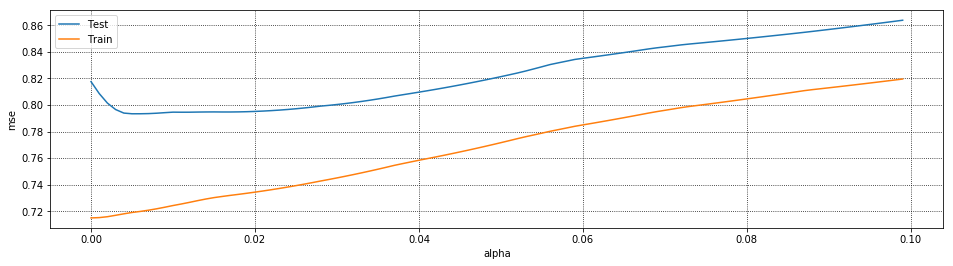

In [32]:
tuningObject.gridSearch(testData,lassoTest,{"alpha":np.arange(1e-5,1e-5+1e-3*100,1e-3)})
tuningObject.showGraph()

## Ridge：交差検証でのグリッドサーチ

,mse_test,mse_train,alpha
14,0.781999,0.72472,14.0


訓練誤差：0.725
汎化誤差：0.782
Optimized alpha：14.0


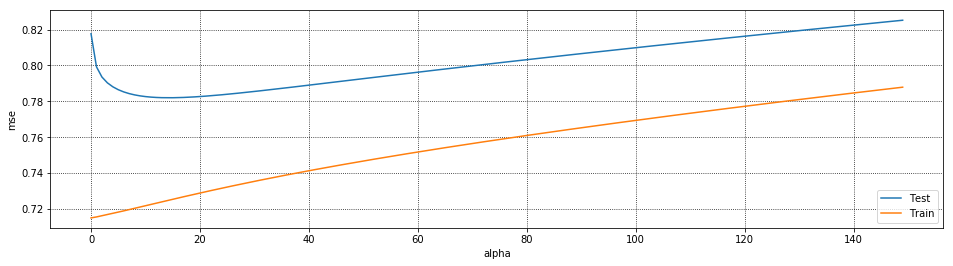

In [33]:
tuningObject.gridSearch(testData,ridgeTest,{"alpha":np.arange(0,0+1*150,1)})
tuningObject.showGraph()

## ElasticNet：交差検証でのグリッドサーチ

,mse_test,mse_train,alpha,l1_ratio
23,0.782009,0.725138,0.047,0.0


訓練誤差：0.725
汎化誤差：0.782
Optimized alpha：0.047


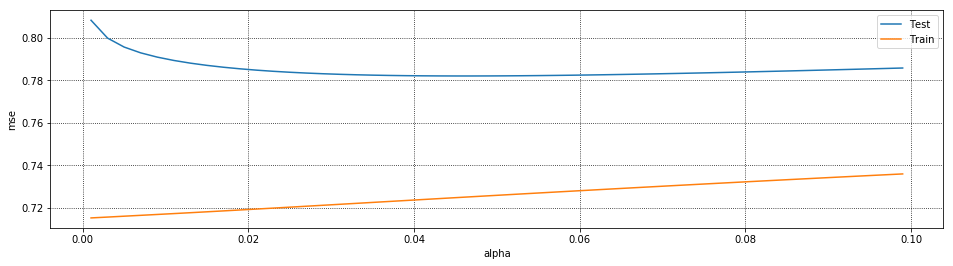


Optimized l1_ratio：0.0


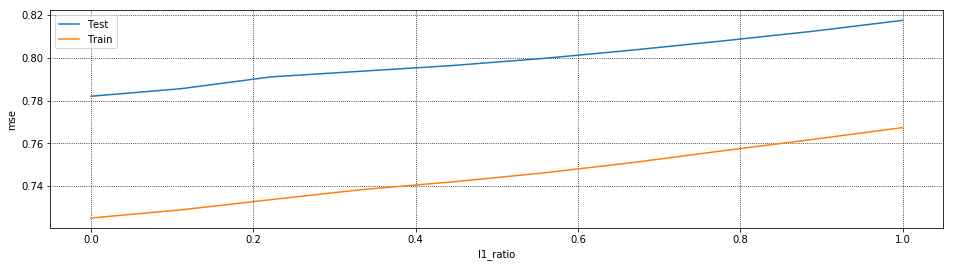

In [34]:
tuningObject.gridSearch(testData,elasticNetTest,{
    "alpha":   np.arange(0.001,0.001+0.002*50,0.002),
    "l1_ratio":np.linspace(0,1,10)})
tuningObject.showGraph()

# Day2実施時のデータを再調整し、最適化したパターン

In [35]:
# Ridge向き
tuningObject.gridSearch(testData,ridgeTest,{"alpha":np.array([14])})
tuningObject.displayBest()
tuningObject.printParam()

,mse_test,mse_train,alpha
0,0.781999,0.72472,14.0


訓練誤差：0.725
汎化誤差：0.782
  重み1：-0.201 重み2：-0.154 重み3：-0.374 重み4：-0.301 重み5：0.298 重み6：-0.133 重み7：0.366 重み8：-0.027 重み9：-0.066 重み10：-0.138
 バイアス：4.947
 訓練 二乗誤差：0.725
 汎化 二乗誤差：0.782



# ここまでがDay2、3の再調整
#### 　・単項式線形回帰モデルに対し、Day3時点のデータに特徴値として
#### 　　給油有無と所要時間を追加した事で精度が向上している事を確認
#### 　　所要時間の追加が影響大きく汎化性能が0.1向上している
#### 　　給油有無は僅かに影響し、汎化性能が0.01向上している
#### 　　遷移としては以下
##### 　　Day2提出時のモデル　→　訓練誤差と汎化誤差が逆転しており、論外
##### 　　Day3提出時のモデル　→　単項式Ridge　汎化性能MSE0.91
##### 　　Day4予習時のモデル　→　単項式Ridge　汎化性能MSE0.78

In [36]:
import re

alphaArray    = np.linspace(0.1,3,20) ** 3
l1ratioArray  = np.linspace(0.001,1,5)
mxdArray      = np.unique(np.append(np.arange(2,16,3),np.arange(8,12)))
mslArray      = np.arange(2,7) ** 2
mssArray      = np.arange(2,7) ** 2 * 2
degreeArray   = np.arange(1,4)
adaboostArray = np.arange(1,31,10)

tuningObjectArray = []

for testFunc,label in [[DTregTest,"DT"],
                        [RFregTest,"RF"],
                        [PolynominalLineTest,"PolynominalLine"],
                        [PolynominalL1Test,"PolynominalL1"],
                        [PolynominalL2Test,"PolynominalL2"],
                        [PolynominalENTest,"PolynominalEN"],
                        [PolynominalDTTest,"PolynominalDT"],
                        [PolynominalRFTest,"PolynominalRF"],
                        [AdaPolynominalLineTest,"AdaPolynominalLine"],
                        [AdaPolynominalL1Test,"AdaPolynominalL1"],
                        [AdaPolynominalL2Test,"AdaPolynominalL2"]]:
    
    hyperParam = {}
    ret = re.search("..$",label)
    if ret != None:
        funcType = label[ret.span()[0]:ret.span()[1]]
        if funcType == "L1" or funcType == "L2" or funcType == "EN":
            hyperParam["alpha"]             = alphaArray
        if funcType == "EN":
            hyperParam["l1_ratio"]          = l1ratioArray
        if funcType == "DT" or funcType == "RF":
            hyperParam["max_depth"]         = mxdArray
            hyperParam["min_samples_leaf"]  = mslArray
            hyperParam["min_samples_split"] = mssArray
            testSet = testDataRaw
        else:
            testSet = testData
            
    ret = re.search("Polynominal",label)
    if ret != None:
        hyperParam["degree"]                = degreeArray
        
    ret = re.search("^Ada",label)
    if ret != None:
        hyperParam["ada_n_estimators"]      = adaboostArray
    
    tuningObj = Tuning()
    tuningObjectArray.append(tuningObj)
    tuningObj.gridSearch(testSet,testFunc,hyperParam)
    print("")
    tuningObj.displayBest(label)



DT


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split
37,0.496701,0.306368,8.0,4.0,18.0


DT訓練誤差：0.306
DT汎化誤差：0.497

RF


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split
5,0.424508,0.238599,11.0,4.0,8.0


RF訓練誤差：0.239
RF汎化誤差：0.425

PolynominalLine


,mse_test,mse_train,degree
0,0.817646,0.715053,1.0


PolynominalLine訓練誤差：0.715
PolynominalLine汎化誤差：0.818

PolynominalL1


,mse_test,mse_train,alpha,degree
41,0.53243,0.343694,0.016124,3.0


PolynominalL1訓練誤差：0.344
PolynominalL1汎化誤差：0.532

PolynominalL2


,mse_test,mse_train,alpha,degree
39,0.584951,0.421014,27.0,2.0


PolynominalL2訓練誤差：0.421
PolynominalL2汎化誤差：0.585

PolynominalEN


,mse_test,mse_train,alpha,l1_ratio,degree
222,0.506192,0.350759,0.06656,0.25075,3.0


PolynominalEN訓練誤差：0.351
PolynominalEN汎化誤差：0.506

PolynominalDT


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,degree
37,0.497346,0.306368,8.0,4.0,18.0,1.0


PolynominalDT訓練誤差：0.306
PolynominalDT汎化誤差：0.497

PolynominalRF


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,degree
6,0.424763,0.23787,14.0,4.0,8.0,1.0


PolynominalRF訓練誤差：0.238
PolynominalRF汎化誤差：0.425

AdaPolynominalLine


,mse_test,mse_train,degree,ada_n_estimators
0,0.905382,0.763563,1.0,1.0


AdaPolynominalLine訓練誤差：0.764
AdaPolynominalLine汎化誤差：0.905

AdaPolynominalL1


,mse_test,mse_train,alpha,degree,ada_n_estimators
21,0.679662,0.49096,0.016124,2.0,1.0


AdaPolynominalL1訓練誤差：0.491
AdaPolynominalL1汎化誤差：0.680

AdaPolynominalL2


,mse_test,mse_train,alpha,degree,ada_n_estimators
39,0.629827,0.469581,27.0,2.0,1.0


AdaPolynominalL2訓練誤差：0.470
AdaPolynominalL2汎化誤差：0.630


In [37]:
import re

alphaArray    = np.linspace(0.1,3,20) ** 3
l1ratioArray  = np.linspace(0.001,1,5)
mxdArray      = np.unique(np.append(np.arange(2,16,3),np.arange(8,12)))
mslArray      = np.arange(2,7) ** 2
mssArray      = np.arange(2,7) ** 2 * 2
degreeArray   = np.arange(1,4)
adaboostArray = np.array([1,10])

tuningObjectArray2 = tuningObjectArray

for testFunc,label in [[AdaPolynominalENTest,"AdaPolynominalEN"],
                        [AdaPolynominalDTTest,"AdaPolynominalDT"],
                        [AdaPolynominalRFTest,"AdaPolynominalRF"],
                        [adbL1Test,"AdaL1"],
                        [adbL2Test,"AdaL2"],
                        [adbENTest,"AdaEN"],
                        [adbDTTest,"AdaDT"],
                        [adbRFTest,"AdaRF"]]:
    
    hyperParam = {}
    ret = re.search("..$",label)
    if ret != None:
        funcType = label[ret.span()[0]:ret.span()[1]]
        if funcType == "L1" or funcType == "L2" or funcType == "EN":
            hyperParam["alpha"]             = alphaArray
        if funcType == "EN":
            hyperParam["l1_ratio"]          = l1ratioArray
        if funcType == "DT" or funcType == "RF":
            hyperParam["max_depth"]         = mxdArray
            hyperParam["min_samples_leaf"]  = mslArray
            hyperParam["min_samples_split"] = mssArray
            testSet = testDataRaw
        else:
            testSet = testData

    ret = re.search("Polynominal",label)
    if ret != None:
        hyperParam["degree"]                = degreeArray
        
    ret = re.search("^Ada",label)
    if ret != None:
        hyperParam["ada_n_estimators"]      = adaboostArray
    
    tuningObj = Tuning()
    tuningObjectArray2.append(tuningObj)
    tuningObj.gridSearch(testSet,testFunc,hyperParam)
    print("")
    tuningObj.displayBest(label)



AdaPolynominalEN


,mse_test,mse_train,alpha,l1_ratio,degree,ada_n_estimators
104,0.592289,0.484542,0.358708,0.001,2.0,1.0


AdaPolynominalEN訓練誤差：0.485
AdaPolynominalEN汎化誤差：0.592

AdaPolynominalDT


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,degree,ada_n_estimators
538,0.494199,0.144155,14.0,9.0,8.0,1.0,10.0


AdaPolynominalDT訓練誤差：0.144
AdaPolynominalDT汎化誤差：0.494

AdaPolynominalRF


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,degree,ada_n_estimators
531,0.457425,0.104884,14.0,4.0,8.0,1.0,10.0


AdaPolynominalRF訓練誤差：0.105
AdaPolynominalRF汎化誤差：0.457

AdaL1


,mse_test,mse_train,alpha,ada_n_estimators
2,0.828029,0.797584,0.06656,1.0


AdaL1訓練誤差：0.798
AdaL1汎化誤差：0.828

AdaL2


,mse_test,mse_train,alpha,ada_n_estimators
19,0.780546,0.741736,27.0,1.0


AdaL2訓練誤差：0.742
AdaL2汎化誤差：0.781

AdaEN


,mse_test,mse_train,alpha,l1_ratio,ada_n_estimators
2,0.781309,0.738539,0.06656,0.001,1.0


AdaEN訓練誤差：0.739
AdaEN汎化誤差：0.781

AdaDT


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,ada_n_estimators
254,0.48747,0.189571,8.0,9.0,32.0,10.0


AdaDT訓練誤差：0.190
AdaDT汎化誤差：0.487

AdaRF


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,ada_n_estimators
185,0.45296,0.200245,9.0,9.0,8.0,10.0


AdaRF訓練誤差：0.200
AdaRF汎化誤差：0.453


# Day3予習時のモデルの再調整
##### 　・多項式回帰モデルと決定木モデルを作成し評価
##### 　　多項式回帰を実施した場合、単項式回帰の場合より精度が向上している事を確認
##### 　　Day3提出時
##### 　　　単項式L2　0.91　→　多項式L2　0.86
##### 　　Day4予習時
##### 　　　単項式EN　0.78　→　多項式EN　0.5　単一の決定木回帰と見劣りせず

##### 　・決定木、ランダムフォレストを作成し評価
##### 　　チューニングせずに実装しても線形回帰モデルより高い精度を誇る事を確認
##### 　　Day3提出時
##### 　　　チューニング無し
##### 　　　　決定木　　　0.81
##### 　　　　RF(ランダムフォレスト)　0.6前後　
##### 　　　チューニング有り
##### 　　　　Ada決定木　0.64
##### 　　　　RF   　　　  0.47
##### 　　Day4予習時
##### 　　　　Ada決定木　0.49
##### 　　　　RF   　　　  0.38　※leafとn_estimatorsのチューニングを追加
##### 　　　　乱択RF   　  0.38　※n_estimatorsを設定せず、乱数制御無しで10試行した場合

# Boosting批評
###### 　Boostingを行う場合、内部制御に乱数の関わらない物が望ましい
###### 　　Boostingの有意性　決定木　＞　ランダムフォレスト（BootstrapのせいでBoostingが台無し）
###### 　線形回帰モデルにBoostingを行う必要性は無い、少なくともAdaboostは逆効果である
###### 　　Boostingの効果　複雑なモデル　＞　簡単なモデル

In [38]:
# 次の課題、モデル調整用の処理を体系化する
# モデルに対して、どの様に変数を処理すれば良いか検討する
# Adboostによる回帰の調整を検討する

In [40]:
tuningObject = Tuning()
tuningObject.gridSearch(testDataRaw,RFregTest,
          {"max_depth":            np.arange(2,5,1),
            "min_samples_leaf":   np.arange(2,10,1),
            "min_samples_split":  np.arange(2,10,1)
          })

tuningObject.displayBest()


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split
5,0.459269,0.335972,4.0,3.0,2.0


訓練誤差：0.336
汎化誤差：0.459


,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,n_estimators
58,0.393985,0.192966,11.0,3.0,2.0,20.0


訓練誤差：0.193
汎化誤差：0.394
Optimized max_depth：11.0


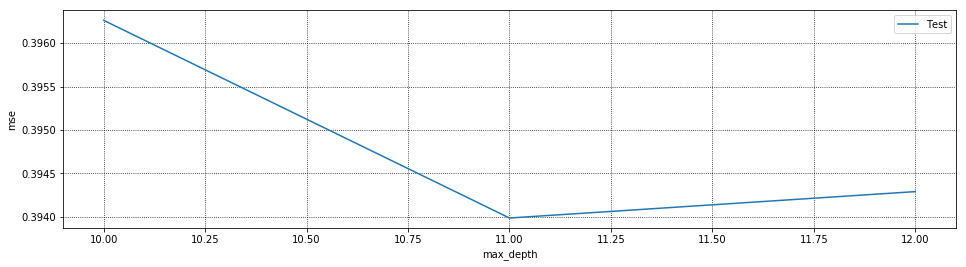


Optimized min_samples_leaf：3.0


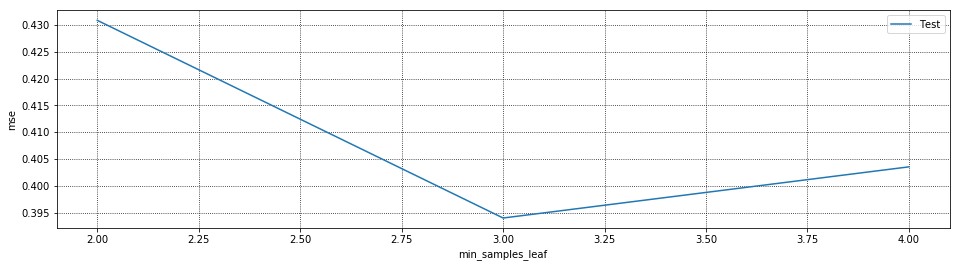


Optimized min_samples_split：2.0


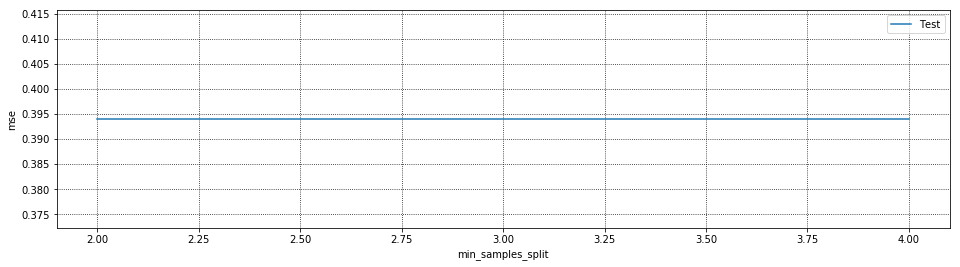


Optimized n_estimators：20.0


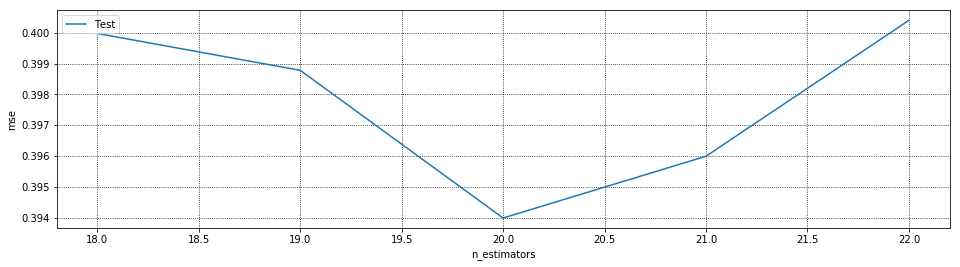

In [45]:
# min_sample_leaf splitで調整した場合、汎化性能が上がることを確認
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataRaw,RFregTest,
          {"max_depth":           np.arange(10,13,1),
            "min_samples_leaf":   np.arange(2,5,1),
            "min_samples_split":  np.arange(2,5,1),
            "n_estimators":       np.arange(18,23),
          })
tuningObject.showGraph(_Train=False)

,mse_test,mse_train,repeat,max_depth,min_samples_leaf,min_samples_split
597,0.398883,0.240739,1.0,10.0,4.0,4.0


訓練誤差：0.241
汎化誤差：0.399
Optimized repeat：1.0


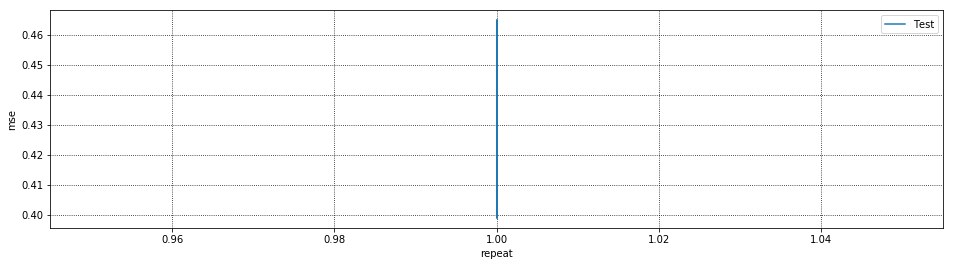


Optimized max_depth：10.0


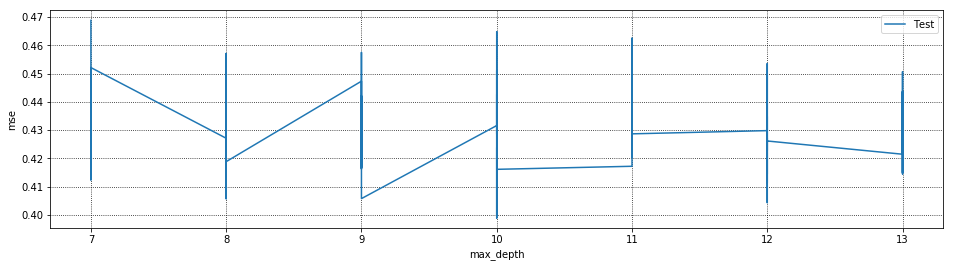


Optimized min_samples_leaf：4.0


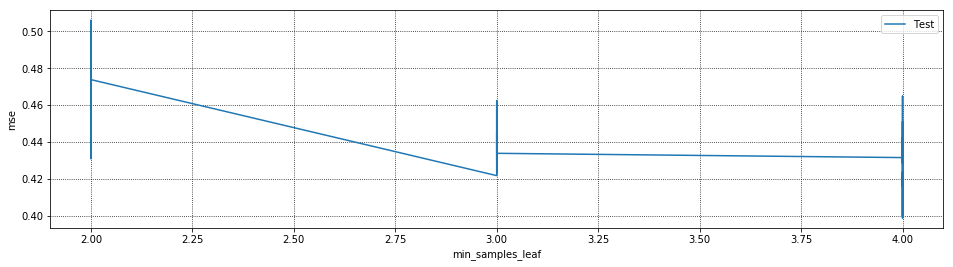


Optimized min_samples_split：4.0


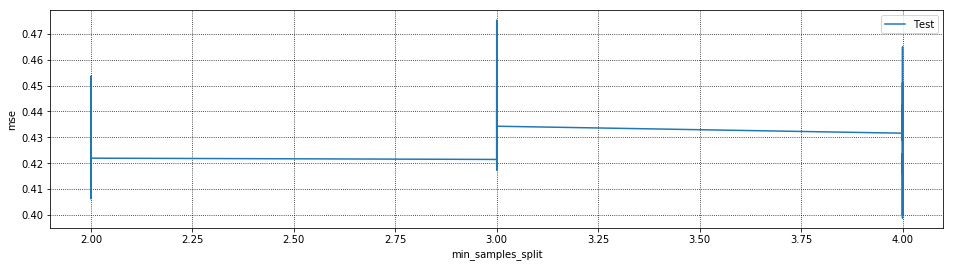

In [46]:
# 乱数不定版、ランダムフォレストで乱数を自由設定にした場合が汎化性能が高い物が生成された
# おそらくBootstrap変化に影響を受けている、単純に試行回数を増やしてテストする
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataRaw,RFregTestNorand,
          { "repeat": np.ones(10),
            "max_depth":          np.arange(7,14),
            "min_samples_leaf":   np.array([2,3,4]),
            "min_samples_split":  np.array([2,3,4]),
          })
tuningObject.showGraph(_Train=False)

,mse_test,mse_train,degree,alpha
73,0.574921,0.442365,2.0,61.7796


訓練誤差：0.442
汎化誤差：0.575
Optimized degree：2.0


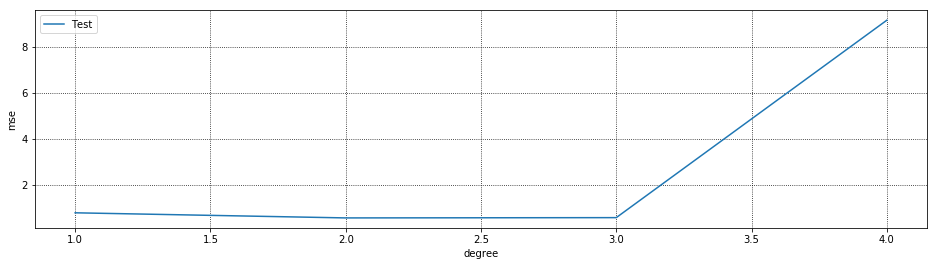


Optimized alpha：61.77959999999988


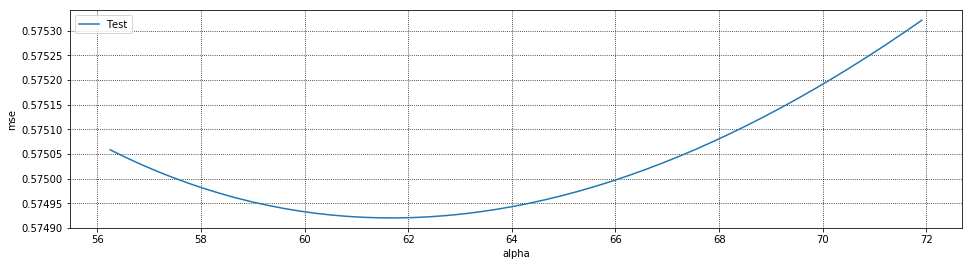

In [57]:
# 曲線Ridgeのテスト、通常のRidgeより性能が向上することを確認
tuningObject = Tuning()
result       = tuningObject.gridSearch(testData,PolynominalL2Test,
          {"degree":np.arange(1,5),
            "alpha":np.arange(7.5,8.5,0.02)**2,
          })

tuningObject.showGraph(_Train=False)


,mse_test,mse_train,degree,alpha,ada_n_estimators
26,0.591733,0.483686,2.0,110.25,1.0


訓練誤差：0.484
汎化誤差：0.592
Optimized degree：2.0


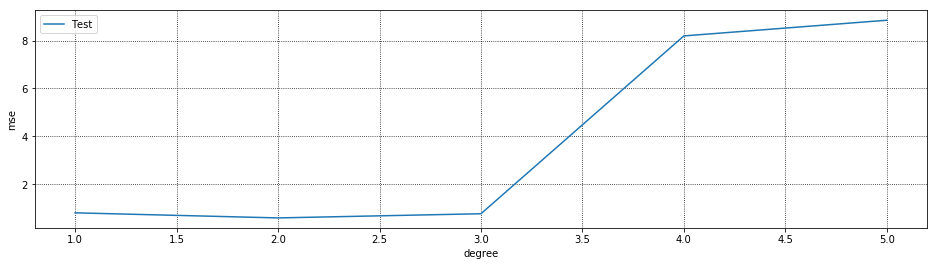


Optimized alpha：110.24999999999996


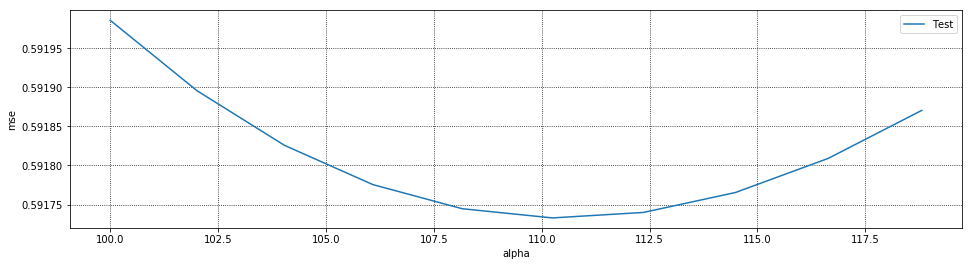


Optimized ada_n_estimators：1.0


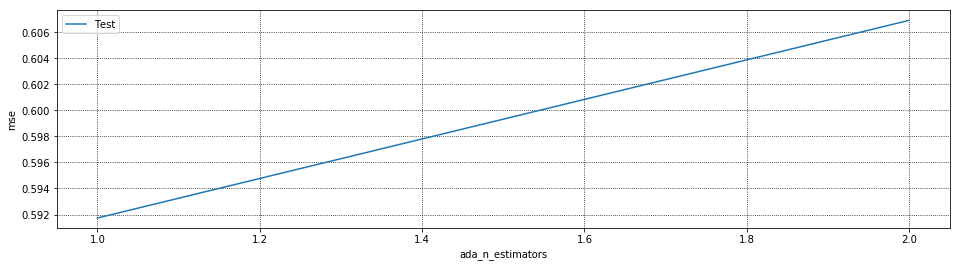

In [62]:
# 曲線Ridgeのテスト、通常のRidgeより性能が向上することを確認
tuningObject = Tuning()
result       = tuningObject.gridSearch(testData,AdaPolynominalL2Test,
          {"degree":           np.arange(1,6),
            "alpha":           np.arange(10,11,0.1)**2,
            "ada_n_estimators":np.arange(1,3),
          })

tuningObject.showGraph(_Train=False)


,mse_test,mse_train,degree
0,0.817646,0.715053,1.0


訓練誤差：0.715
汎化誤差：0.818
Optimized degree：1.0


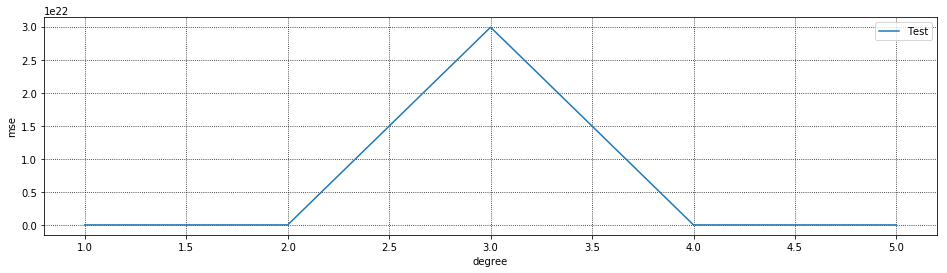

In [50]:
# 曲線Ridgeのテスト、通常のRidgeより性能が向上することを確認
tuningObject = Tuning()
result            = tuningObject.gridSearch(testData,PolynominalLineTest,
          {"degree":         np.arange(1,6),
          })

tuningObject.showGraph(_Train=False)


,mse_test,mse_train,degree,ada_n_estimators
0,0.905382,0.763563,1.0,1.0


訓練誤差：0.764
汎化誤差：0.905
Optimized degree：1.0


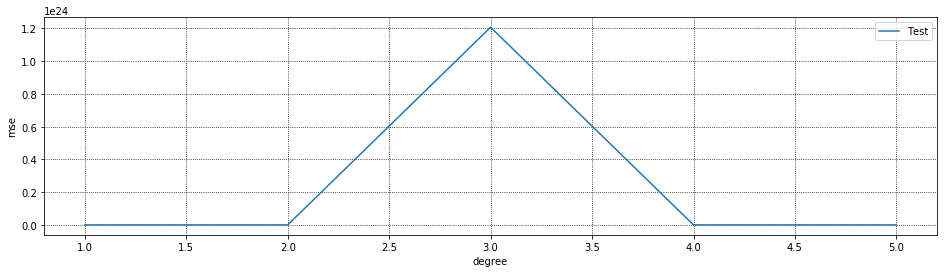


Optimized ada_n_estimators：1.0


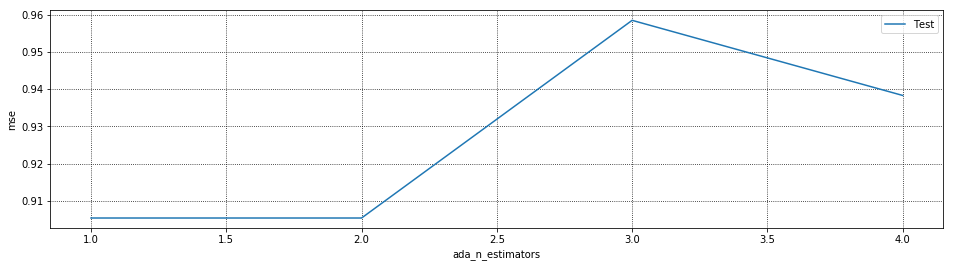

In [51]:
# 曲線Ridgeのテスト、通常のRidgeより性能が向上することを確認
tuningObject = Tuning()
result            = tuningObject.gridSearch(testData,AdaPolynominalLineTest,
          {"degree":         np.arange(1,6),
            "ada_n_estimators":np.arange(1,5),
          })

tuningObject.showGraph(_Train=False)


# 回帰モデル、木モデル調査結果
### 　・ランダムフォレスト回帰が最も良い成績を収める
### 　　また、ランダムフォレスト回帰を行う場合、無相関化を行わない方が精度が上がっている
### 　・単純な回帰の場合、PolynominalのDegree2辺りでElasticNetを使うとそれなりに精度が上がった
### 　　ただし、木モデルには及ばず、グラフ化あるいは補助変数生成に使用する事を検討
### 　・乱数不定版で試行回数を増やし乱択してもそれなりに精度の高いモデルが出現する
### 　　これはグリッドサーチをランダムサーチにするのと同じ所以

In [52]:
# min_sample_leaf splitで調整した場合、汎化性能が上がることを確認
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataRaw,RFregTest,
          {"max_depth":           np.arange(11,12),
            "min_samples_leaf":   np.arange(3,4),
            "min_samples_split":  np.arange(2,3),
            "n_estimators":       np.arange(20,21),
          })
tuningObject.displayBest()

,mse_test,mse_train,max_depth,min_samples_leaf,min_samples_split,n_estimators
0,0.393985,0.192966,11.0,3.0,2.0,20.0


訓練誤差：0.193
汎化誤差：0.394


In [65]:
tuningObject = Tuning()
result = tuningObject.gridSearch(testData,PolynominalENTest,
          { "alpha":          np.array([0.0777]),
            "l1_ratio":   np.array([0.18]),
            "degree":  np.array([3]),
          })
tuningObject.displayBest()


,mse_test,mse_train,alpha,l1_ratio,degree
0,0.502714,0.346035,0.0777,0.18,3.0


訓練誤差：0.346
汎化誤差：0.503


,mse_test,mse_train,repeat,max_depth,min_samples_leaf,min_samples_split
112,0.382407,0.213001,1.0,11.0,3.0,2.0


訓練誤差：0.213
汎化誤差：0.382
Optimized repeat：1.0


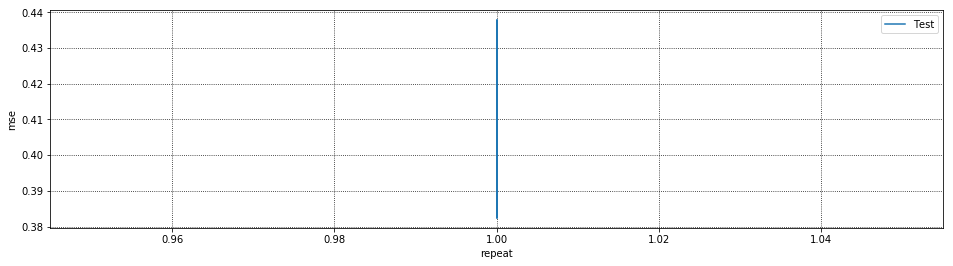


Optimized max_depth：11.0


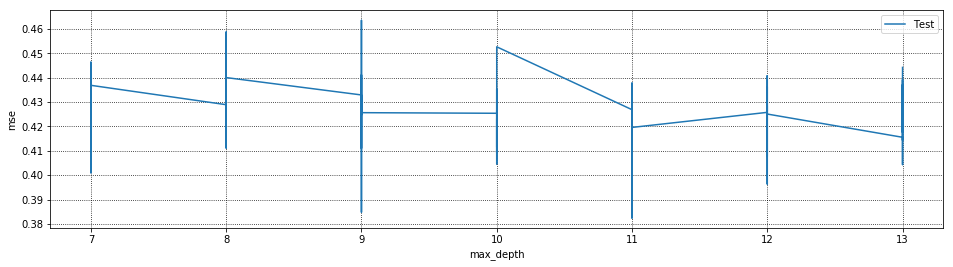


Optimized min_samples_leaf：3.0


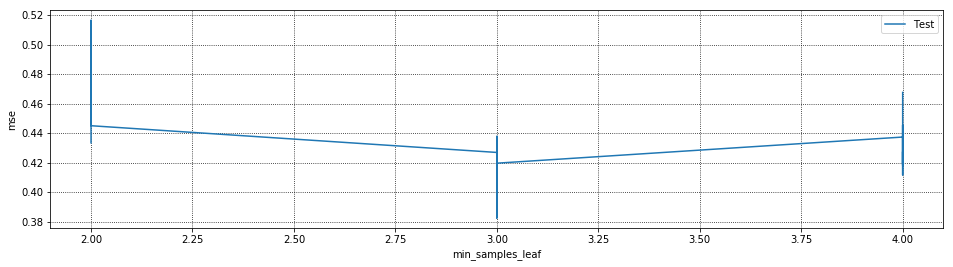


Optimized min_samples_split：2.0


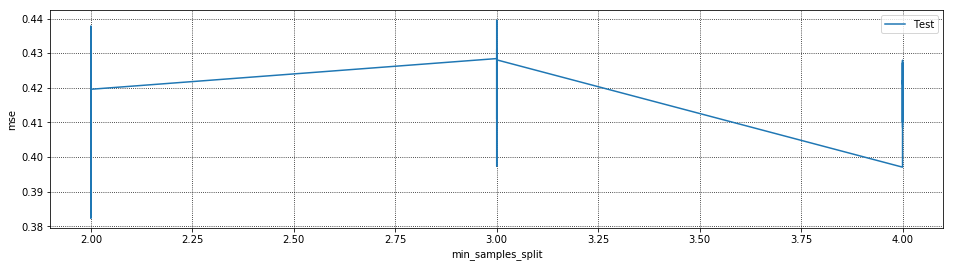

In [102]:
# 乱数不定版、ランダムフォレストで乱数を自由設定にした場合が汎化性能が高い物が生成された
# おそらくBootstrap変化に影響を受けている、単純に試行回数を増やしてテストする
tuningObject = Tuning()
result = tuningObject.gridSearch(testDataRaw,RFregTestNorand,
          { "repeat": np.ones(10),
            "max_depth":          np.arange(7,14),
            "min_samples_leaf":   np.array([2,3,4]),
            "min_samples_split":  np.array([2,3,4]),
          })
tuningObject.showGraph(_Train=False)

# 検討作業
###### 　criterionは変更していない、勾配Boostingは使用していない、ML4の後に実施する、先にNNの検証を行う
# TODO
###### 　TODO１：NN検証
###### 　TODO２：サーチモデルの所要時間と試行回数表示拡張　※内部モデルが多い物は所要時間が10倍、100倍になる為
###### 　TODO３：木モデルのcriterion変更確認
###### 　TODO４：勾配Boostingの確認



# NN系の調査

In [113]:
# 実施する時間があれば対応